# Beta

In [1]:
import seaborn as sn
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from datetime import datetime
import numpy as np
from itertools import permutations

from qiskit_finance.data_providers import YahooDataProvider
import json # Necessary for YahooDataProvider
import http.client # Necessary for YahooDataProvider

import pandas as pd
import pandas_datareader as web

import os

from docplex.mp.model import Model

from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.converters import LinearEqualityToPenalty

from qiskit.circuit.library import TwoLocal # For Ansatz

from qiskit.algorithms.optimizers import COBYLA, ADAM, NELDER_MEAD, POWELL, SPSA, QNSPSA
from qiskit.opflow import CVaRExpectation
from qiskit.opflow import PauliExpectation

from qiskit.algorithms import VQE
from qiskit.algorithms import QAOA

from qiskit import Aer

In [2]:
# Import custom function 
import sys
sys.path.append('../python')
# from base import 
import plotly.express as px

## Loading Data

### Data from CSV file 

In [3]:
df = pd.read_csv("../data/Index_data/seoul_5year_250steps_25gu.csv", encoding="UTF-8", header= "infer")
date = pd.date_range("2017-9-11", "2022-9-5", periods= 250)
df.index = date.normalize()
df = df.drop('Unnamed: 0', axis = 1)
# cov_matrix = df.cov()
df.head()

,전국,서울,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,...,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구,수도권
2017-09-11,73.431,63.768,75.319,70.493,65.815,65.705,65.650,66.073,67.745,64.093,...,61.130,66.277,60.562,62.045,66.802,68.752,65.605,62.143,67.035,65.095
2017-09-18,73.444,63.819,75.437,70.547,65.831,65.777,65.774,66.150,67.864,64.144,...,61.197,66.376,60.606,62.122,66.834,68.777,65.659,62.209,67.130,65.126
2017-09-25,73.463,63.891,75.604,70.666,65.898,65.872,65.890,66.183,68.000,64.211,...,61.265,66.429,60.699,62.187,66.946,68.809,65.733,62.306,67.234,65.166
2017-10-02,73.480,63.958,75.604,70.813,65.921,66.026,66.058,66.213,68.040,64.304,...,61.327,66.582,60.819,62.226,66.963,68.905,65.832,62.436,67.342,65.198
2017-10-10,73.505,64.053,75.696,70.975,66.067,66.188,66.192,66.314,68.105,64.367,...,61.375,66.708,60.963,62.337,67.014,68.999,65.959,62.646,67.458,65.245


#### Calculate the mean - Pereiod Return's $\Sigma$

In [4]:
df_return = df.pct_change(periods= 2)
df_return.tail()

,전국,서울,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,...,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구,수도권
2022-08-06,-0.000855,-0.000477,-0.000246,-0.000359,0.000214,-0.000119,-0.000157,0.000000,0.0000,-0.002051,...,-0.000139,0.000000,-0.000089,-0.000387,0.000010,0.000069,-0.000393,-0.000658,-0.000130,-0.000958
2022-08-14,-0.001064,-0.000786,-0.000148,-0.000728,0.000205,-0.000119,-0.000157,-0.000461,0.0000,-0.002112,...,-0.000259,0.000000,-0.000138,-0.000645,-0.000130,0.000059,-0.000708,-0.001236,-0.000210,-0.001288
2022-08-21,-0.001045,-0.000826,0.000039,-0.000369,0.000205,0.000000,-0.000187,-0.000611,0.0000,-0.000514,...,-0.000508,-0.000305,-0.000346,-0.000794,-0.000140,-0.000147,-0.000393,-0.001635,-0.000869,-0.001329
2022-08-28,-0.001444,-0.001095,-0.000108,-0.000479,0.000019,-0.000109,-0.002205,-0.000180,0.0000,-0.001481,...,-0.000468,-0.001940,-0.000336,-0.000914,-0.000728,-0.000294,-0.000394,-0.002464,-0.002069,-0.001769
2022-09-05,-0.001833,-0.001553,-0.000148,-0.000619,-0.000127,-0.000457,-0.002245,-0.001923,-0.0001,-0.002257,...,-0.000936,-0.002256,-0.000119,-0.000616,-0.000728,-0.000382,-0.000649,-0.003135,-0.001510,-0.002311


In [11]:
# Period 간의 수익률을 구해주는 pandas 내장 function -> 초기값 처리로 Base function 만들어주자 
return_cov_matrix = df_return.cov()
return_cov_matrix

,전국,서울,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,...,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구,수도권
전국,0.000010,0.000008,0.000004,0.000007,0.000006,0.000007,0.000005,0.000008,0.000008,0.000009,...,0.000010,0.000006,0.000006,0.000008,0.000008,0.000007,0.000005,0.000007,0.000007,0.000012
서울,0.000008,0.000013,0.000007,0.000010,0.000010,0.000012,0.000010,0.000013,0.000011,0.000014,...,0.000015,0.000010,0.000012,0.000014,0.000012,0.000012,0.000011,0.000013,0.000011,0.000011
종로구,0.000004,0.000007,0.000007,0.000005,0.000006,0.000006,0.000005,0.000006,0.000006,0.000007,...,0.000007,0.000005,0.000006,0.000006,0.000006,0.000006,0.000005,0.000006,0.000006,0.000005
중구,0.000007,0.000010,0.000005,0.000010,0.000008,0.000008,0.000007,0.000010,0.000008,0.000010,...,0.000011,0.000007,0.000009,0.000011,0.000009,0.000008,0.000007,0.000009,0.000008,0.000009
용산구,0.000006,0.000010,0.000006,0.000008,0.000014,0.000009,0.000007,0.000011,0.000008,0.000010,...,0.000011,0.000006,0.000010,0.000011,0.000009,0.000010,0.000010,0.000010,0.000010,0.000009
성동구,0.000007,0.000012,0.000006,0.000008,0.000009,0.000016,0.000010,0.000012,0.000009,0.000012,...,0.000012,0.000009,0.000011,0.000012,0.000009,0.000011,0.000011,0.000014,0.000011,0.000009
광진구,0.000005,0.000010,0.000005,0.000007,0.000007,0.000010,0.000011,0.000009,0.000007,0.000010,...,0.000010,0.000008,0.000009,0.000009,0.000008,0.000009,0.000009,0.000012,0.000008,0.000007
동대문구,0.000008,0.000013,0.000006,0.000010,0.000011,0.000012,0.000009,0.000016,0.000011,0.000014,...,0.000015,0.000010,0.000012,0.000015,0.000012,0.000012,0.000010,0.000012,0.000011,0.000012
중랑구,0.000008,0.000011,0.000006,0.000008,0.000008,0.000009,0.000007,0.000011,0.000012,0.000012,...,0.000013,0.000008,0.000010,0.000011,0.000009,0.000009,0.000008,0.000010,0.000009,0.000011
성북구,0.000009,0.000014,0.000007,0.000010,0.000010,0.000012,0.000010,0.000014,0.000012,0.000018,...,0.000017,0.000012,0.000014,0.000015,0.000013,0.000012,0.000010,0.000013,0.000011,0.000012


In [12]:
df_return.corr()

,전국,서울,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,...,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구,수도권
전국,1.000000,0.717102,0.532845,0.668496,0.546873,0.522648,0.485341,0.665701,0.751564,0.662741,...,0.676026,0.569862,0.526555,0.624505,0.655281,0.600089,0.426592,0.539380,0.619952,0.975067
서울,0.717102,1.000000,0.691222,0.821502,0.741269,0.830418,0.814577,0.909700,0.870862,0.929963,...,0.913025,0.799689,0.913076,0.882192,0.888524,0.863193,0.771756,0.851040,0.859194,0.806026
종로구,0.532845,0.691222,1.000000,0.590981,0.598636,0.591067,0.563252,0.570152,0.687054,0.634274,...,0.632821,0.523650,0.637580,0.557494,0.638151,0.665232,0.548071,0.556554,0.641047,0.545752
중구,0.668496,0.821502,0.590981,1.000000,0.635672,0.641546,0.647542,0.758107,0.717086,0.768201,...,0.757126,0.611720,0.755960,0.782126,0.785143,0.656430,0.597319,0.644668,0.731883,0.711017
용산구,0.546873,0.741269,0.598636,0.635672,1.000000,0.632367,0.610579,0.707594,0.633995,0.645153,...,0.626829,0.479364,0.709719,0.683759,0.685848,0.744978,0.675332,0.608188,0.737763,0.608897
성동구,0.522648,0.830418,0.591067,0.641546,0.632367,1.000000,0.786263,0.755835,0.685257,0.725718,...,0.683159,0.600649,0.708849,0.714978,0.637024,0.731816,0.718056,0.808660,0.787479,0.604355
광진구,0.485341,0.814577,0.563252,0.647542,0.610579,0.786263,1.000000,0.700742,0.650075,0.741820,...,0.655692,0.710498,0.729034,0.616914,0.651185,0.712790,0.760148,0.839787,0.728402,0.571380
동대문구,0.665701,0.909700,0.570152,0.758107,0.707594,0.755835,0.700742,1.000000,0.802263,0.828622,...,0.819683,0.704884,0.820150,0.857380,0.831382,0.777647,0.630440,0.720208,0.814439,0.765076
중랑구,0.751564,0.870862,0.687054,0.717086,0.633995,0.685257,0.650075,0.802263,1.000000,0.809584,...,0.841000,0.682571,0.743490,0.723363,0.746474,0.736729,0.592738,0.685308,0.743095,0.805672
성북구,0.662741,0.929963,0.634274,0.768201,0.645153,0.725718,0.741820,0.828622,0.809584,1.000000,...,0.878447,0.758113,0.858809,0.824326,0.858403,0.745104,0.628842,0.744589,0.741641,0.753830


In [13]:


A = 5000 *return_cov_matrix
A

,전국,서울,종로구,중구,용산구,성동구,광진구,동대문구,중랑구,성북구,...,구로구,금천구,영등포구,동작구,관악구,서초구,강남구,송파구,강동구,수도권
전국,0.050341,0.041270,0.021969,0.034207,0.032320,0.033220,0.025148,0.042179,0.040973,0.044447,...,0.048657,0.032496,0.031178,0.042255,0.037511,0.035381,0.025885,0.036272,0.034565,0.059765
서울,0.041270,0.065793,0.032580,0.048057,0.050083,0.060342,0.048252,0.065895,0.054277,0.071301,...,0.075126,0.052133,0.061807,0.068240,0.058147,0.058182,0.053536,0.065426,0.054765,0.056479
종로구,0.021969,0.032580,0.033767,0.024767,0.028976,0.030769,0.023903,0.029587,0.030677,0.034839,...,0.037303,0.024456,0.030918,0.030894,0.029918,0.032123,0.027237,0.030652,0.029272,0.027396
중구,0.034207,0.048057,0.024767,0.052012,0.038187,0.041449,0.034105,0.048825,0.039737,0.052368,...,0.055391,0.035458,0.045498,0.053792,0.045684,0.039340,0.036841,0.044066,0.041478,0.044298
용산구,0.032320,0.050083,0.028976,0.038187,0.069383,0.047188,0.037142,0.052635,0.040578,0.050796,...,0.052965,0.032092,0.049335,0.054314,0.046091,0.051566,0.048108,0.048015,0.048291,0.043815
성동구,0.033220,0.060342,0.030769,0.041449,0.047188,0.080254,0.051440,0.060467,0.047170,0.061453,...,0.062083,0.043247,0.052994,0.061082,0.046042,0.054479,0.055013,0.068661,0.055436,0.046771
광진구,0.025148,0.048252,0.023903,0.034105,0.037142,0.051440,0.053333,0.045700,0.036478,0.051208,...,0.048575,0.041703,0.044431,0.042964,0.038368,0.043256,0.047476,0.058127,0.041801,0.036047
동대문구,0.042179,0.065895,0.029587,0.048825,0.052635,0.060467,0.045700,0.079748,0.055049,0.069945,...,0.074255,0.050592,0.061121,0.073016,0.059900,0.057708,0.048148,0.060958,0.057153,0.059022
중랑구,0.040973,0.054277,0.030677,0.039737,0.040578,0.047170,0.036478,0.055049,0.059041,0.058800,...,0.065552,0.042153,0.047675,0.053005,0.046276,0.047041,0.038951,0.049908,0.044868,0.053479
성북구,0.044447,0.071301,0.034839,0.052368,0.050796,0.061453,0.051208,0.069945,0.058800,0.089347,...,0.084231,0.057594,0.067745,0.074306,0.065463,0.058526,0.050834,0.066707,0.055088,0.061555


#### Assets

In [6]:
realestates = df.columns.to_list()
[print(realestate + "   ") for realestate in realestates];

전국   
서울   
종로구   
중구   
용산구   
성동구   
광진구   
동대문구   
중랑구   
성북구   
강북구   
도봉구   
노원구   
은평구   
서대문구   
마포구   
양천구   
강서구   
구로구   
금천구   
영등포구   
동작구   
관악구   
서초구   
강남구   
송파구   
강동구   
수도권   


In [7]:
# 서울의 동만 남기고 
df_gu = df.drop('전국',axis= 1)
df_gu = df.drop('수도권',axis= 1)

In [8]:
# Normalize gu data based on initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

# Function to plot interactive plot
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = list(df.index), y = df[i], name = i)
  fig.show()

# calulate the daily return instead of 'pct_change'
def daily_return(df):
  df_daily_return = df.copy()
  for i in df.columns[1:]:
    for j in range(1, len(df)):
      df_daily_return[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100
    df_daily_return[i][0] = 0
  return df_daily_return

In [9]:
df_gu = normalize(df_gu)

In [10]:
interactive_plot(df_gu, 'Time plot based index Price')

In [11]:
DailyRetrn_df_gu = daily_return(df_gu).drop('전국', axis = 1)

In [12]:
# 한국어 폰트 문제 해결 
import matplotlib as mpl
# plt.rc('font', family='Malgun Gothic')                  # 윈도우 & colab 환경 
mpl.rc('font', family='AppleGothic')                   # 맥북 환경
mpl.rcParams['axes.unicode_minus'] = False              # 유니코드 마이너스 기호 부분의 이슈 

Text(0.5, 1.0, 'Daily returns of the gus')

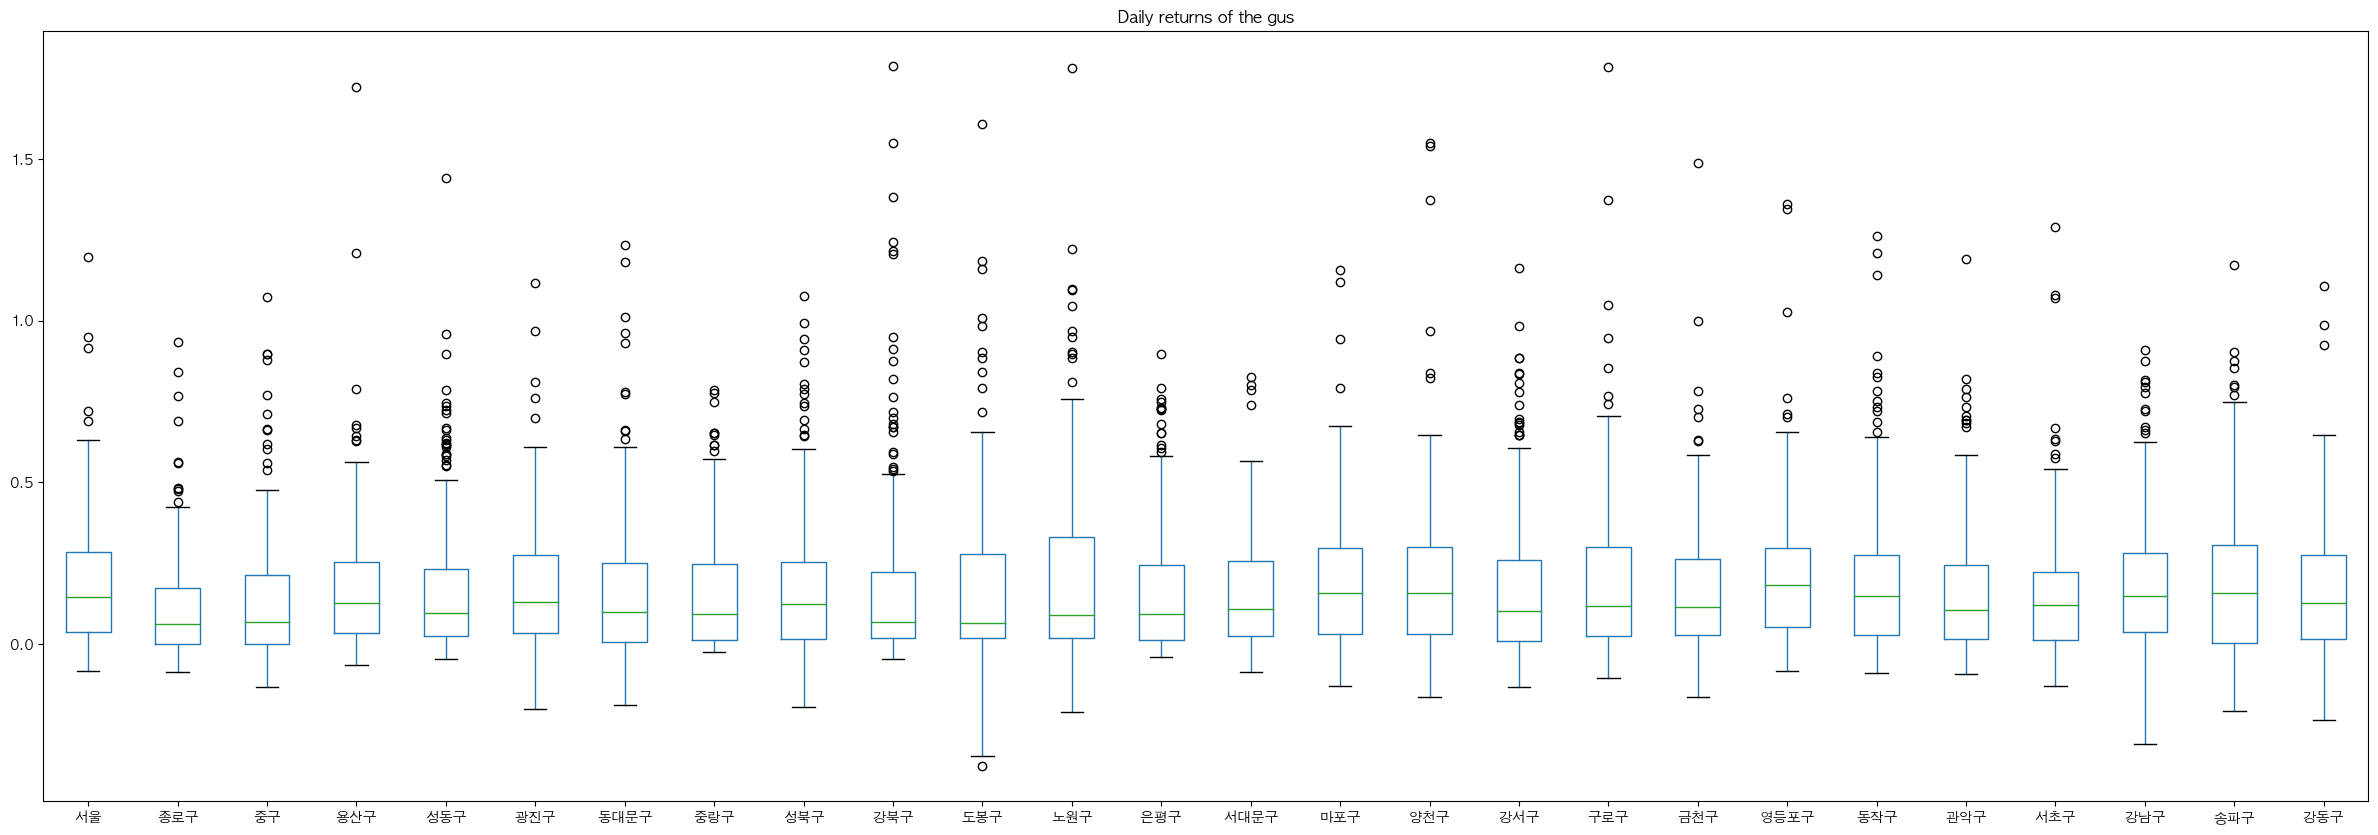

In [13]:
# 나중에 PLT 한국어 font 추가 
DailyRetrn_df_gu.boxplot(figsize=(30, 10), grid=False)
plt.title("Daily returns of the gus")

In [14]:
DailyRetrn_df_gu.columns

Index(['서울', '종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구',
       '동작구', '관악구', '서초구', '강남구', '송파구', '강동구'],
      dtype='object')

In [ ]:
eval()

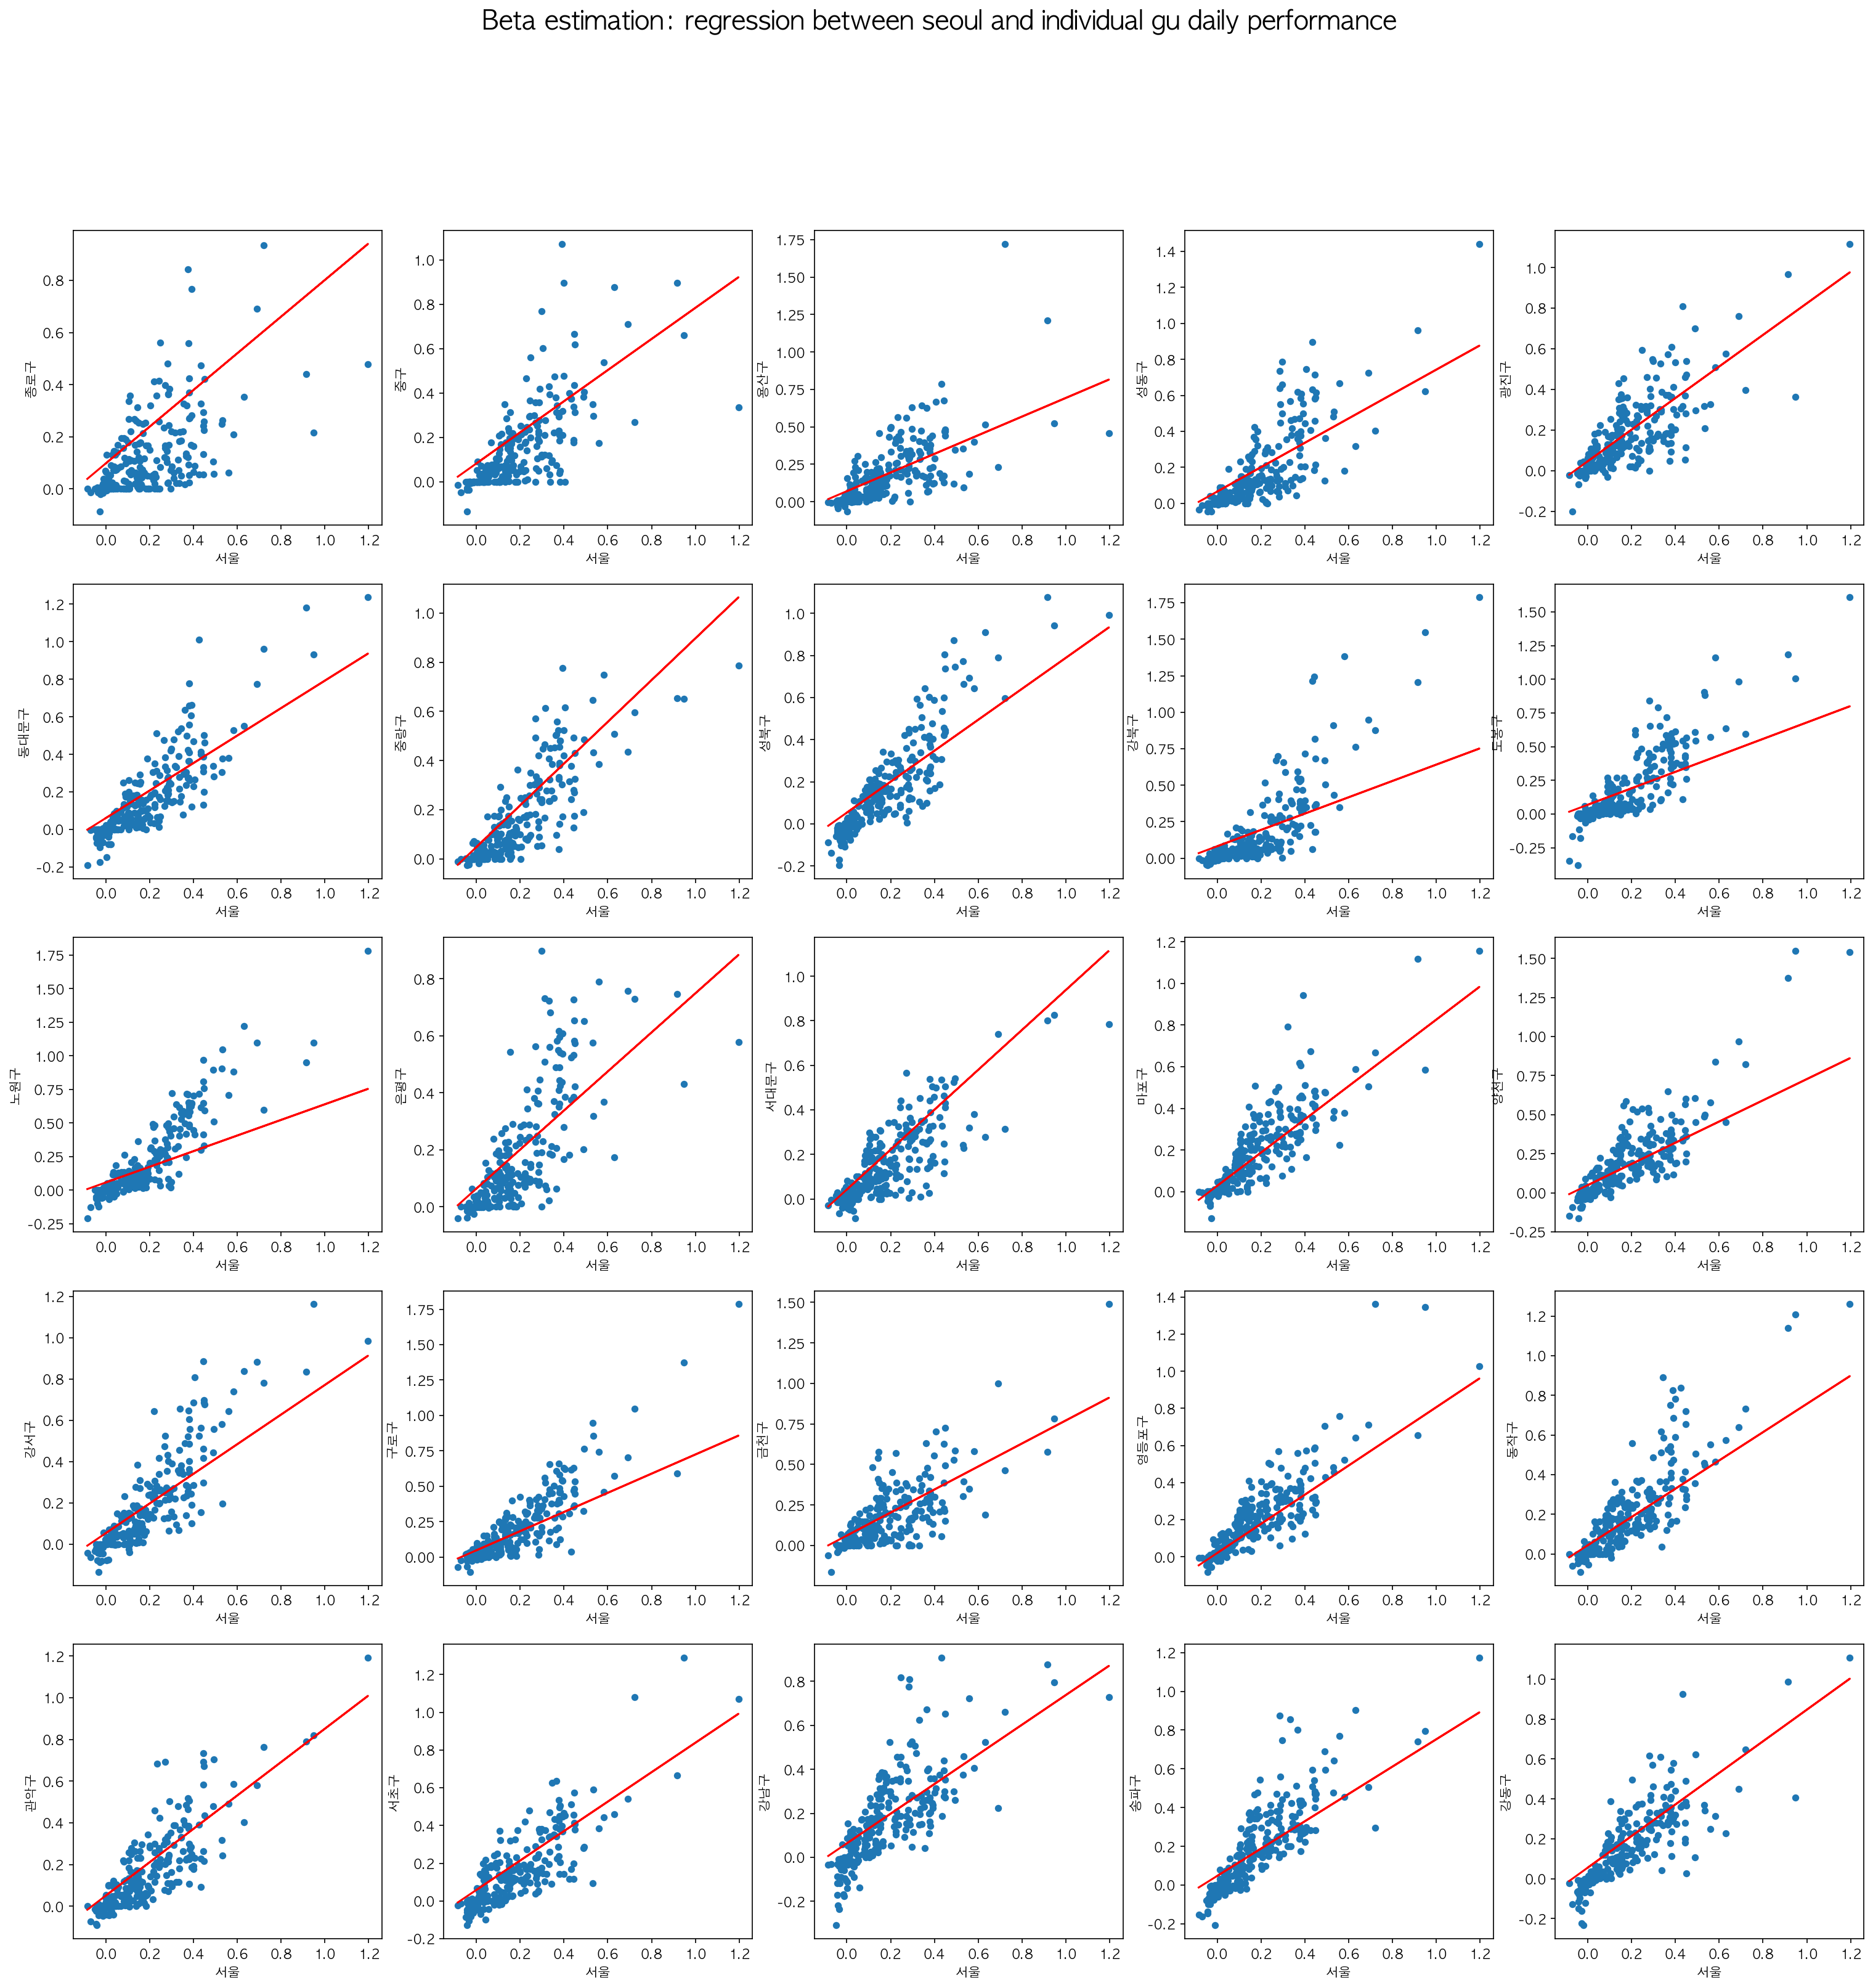

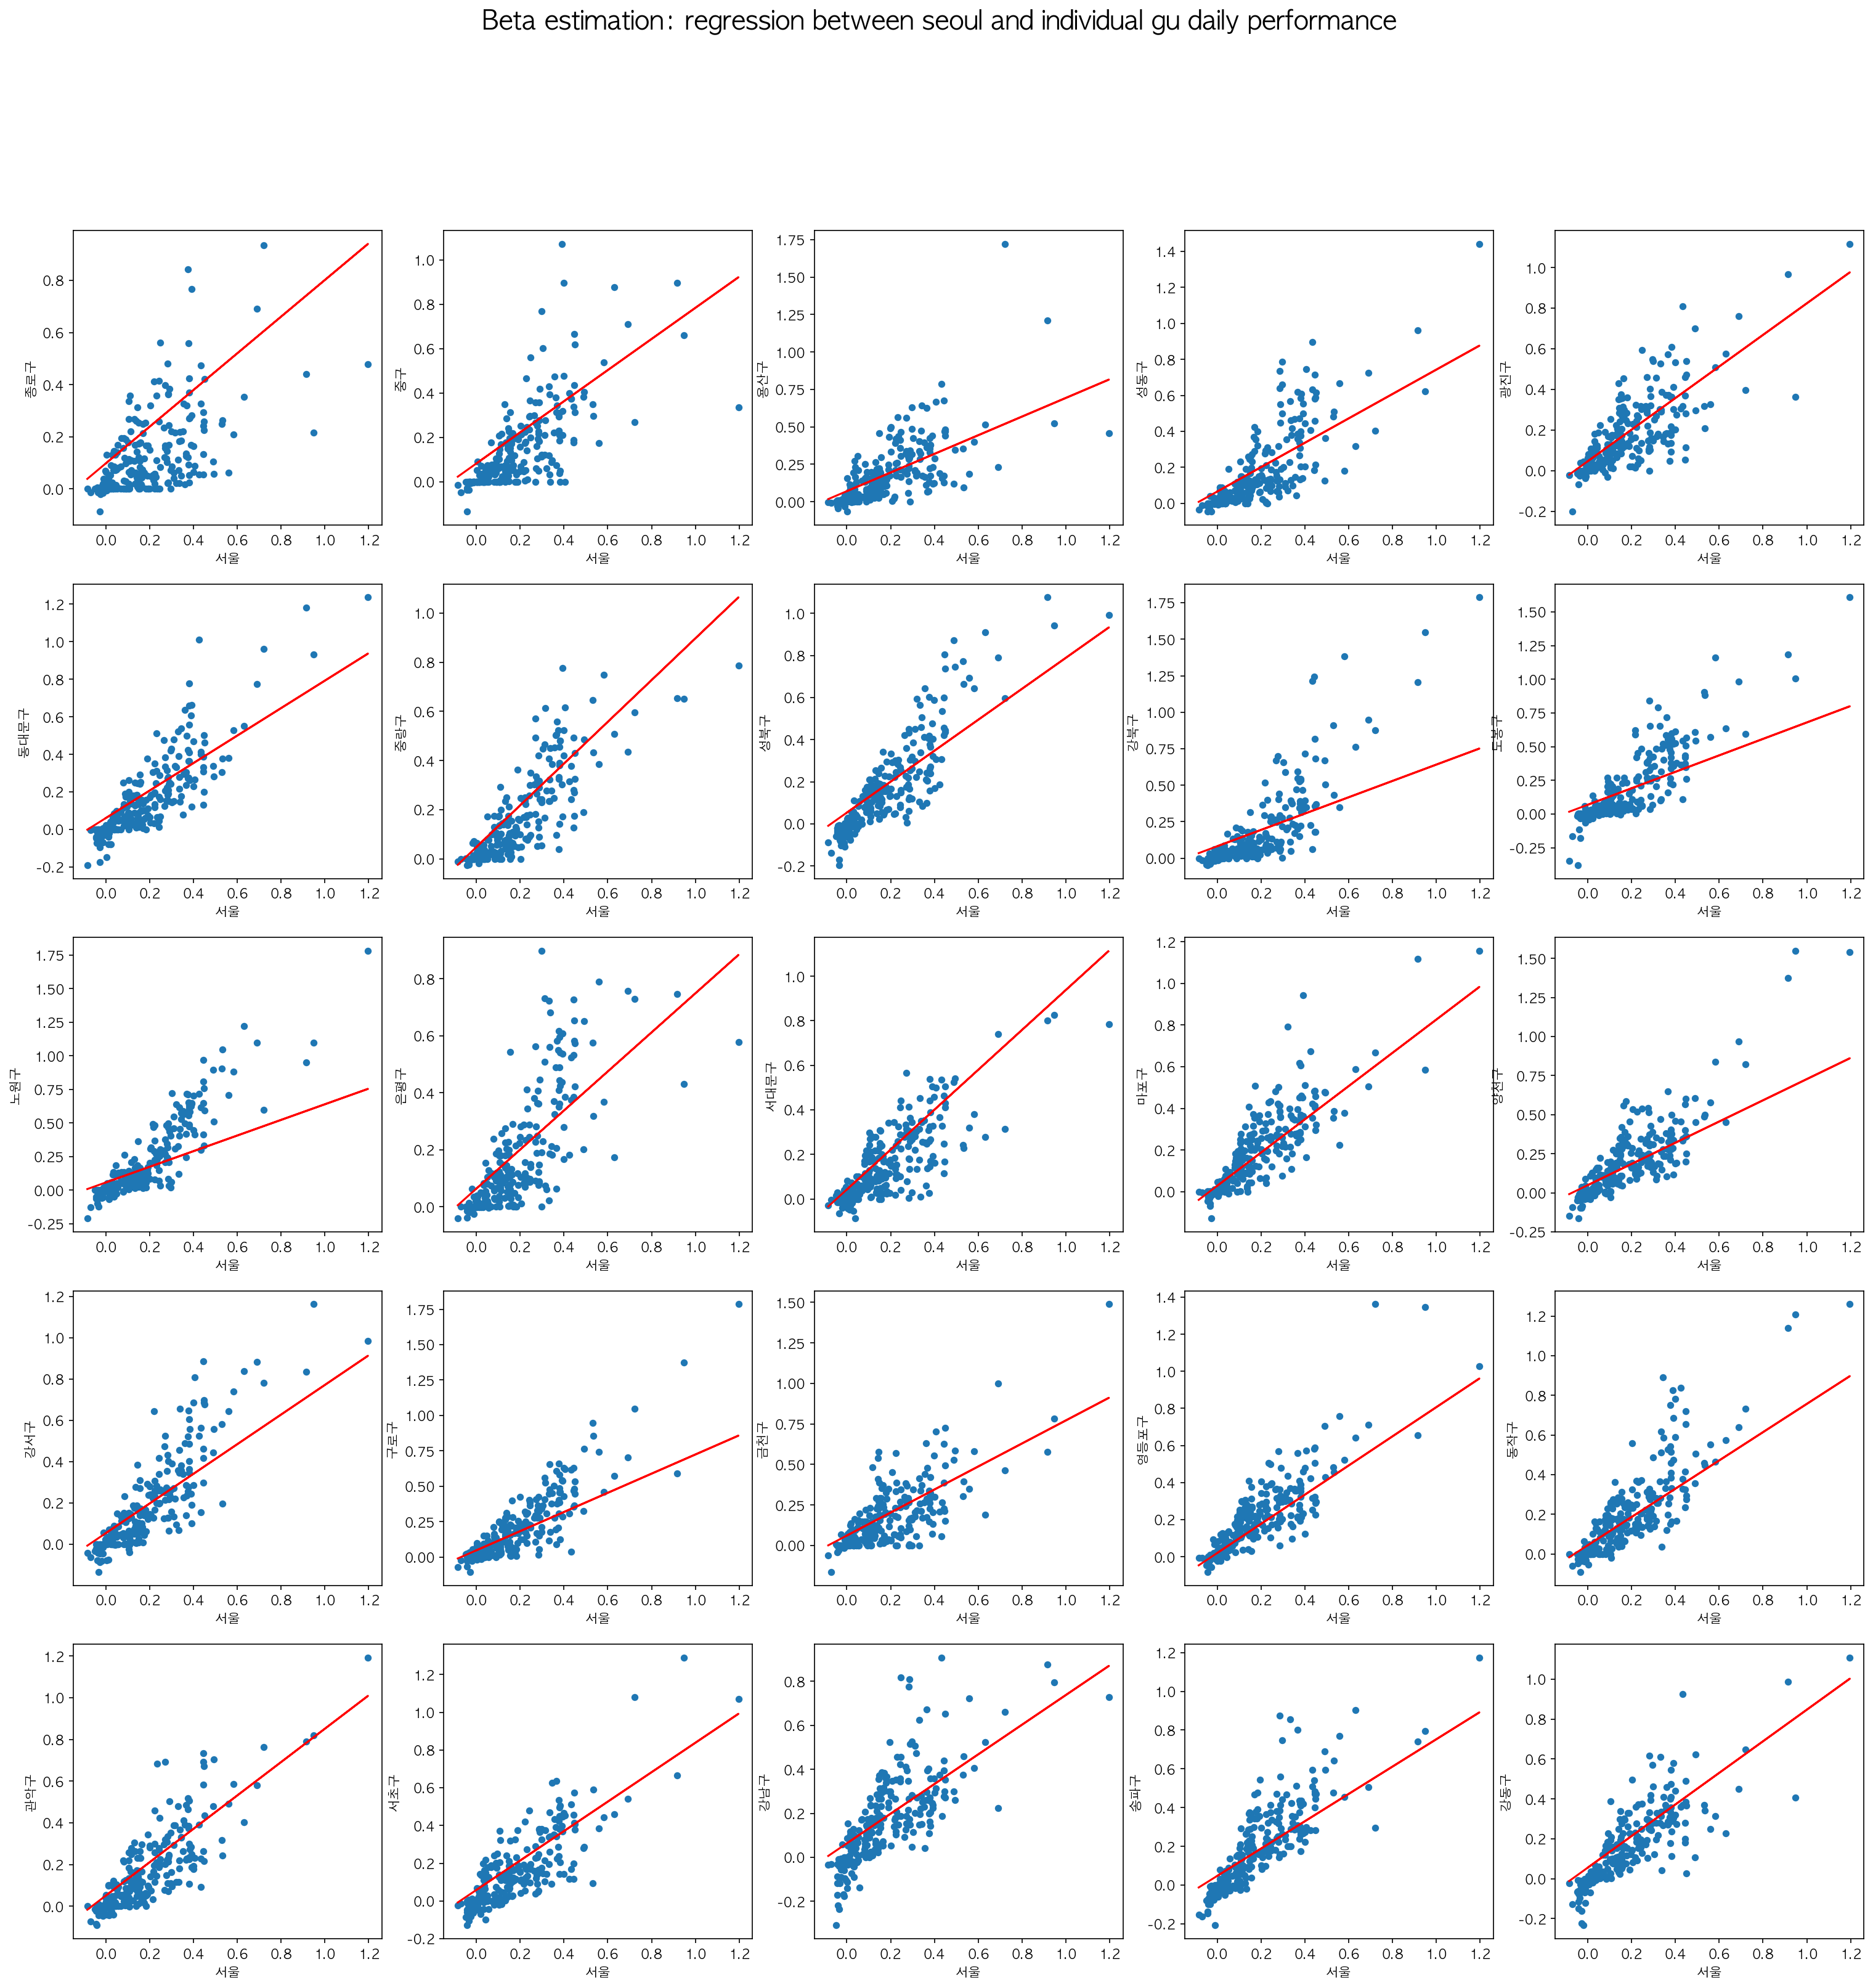

In [21]:
# Initialize empty dictionaries to save results
beta,alpha = dict(), dict()
# Make a nice subplot
fig, axes = plt.subplots(5,5, dpi=150, figsize=(25,24))
axes = axes.flatten()
# Loop on every stock daily return
for idx, gu in enumerate(DailyRetrn_df_gu.columns):
# Ignoring the date and 서울 Columns 
    if gu != "Date" and gu != "서울":
        # scatter plot between gu and the 서울
        DailyRetrn_df_gu.plot(kind = "scatter", x = "서울", y = gu, ax=axes[idx-1])
 
        # Fit a line (regression using polyfit of degree 1)
        b_, a_ = np.polyfit(DailyRetrn_df_gu[gu], DailyRetrn_df_gu["서울"], 1)
        regression_line = b_ * DailyRetrn_df_gu["서울"] + a_
        axes[idx-1].plot(DailyRetrn_df_gu["서울"], regression_line, "-", color = "r")
        # save the regression coeeficient for the current stock
        beta[gu] = b_
        alpha[gu] = a_
plt.suptitle("Beta estimation: regression between seoul and individual gu daily performance", size=20)
plt.show()

In [22]:
print('a','b')
print('a' + 'b')

a b
ab


### Beta 

In [18]:
## Print Beta beta 는 딕셔너리로 저장되어 있음 ㅇㅇ 
beta

{'종로구': 0.7043230350406724,
 '중구': 0.7013707352553286,
 '용산구': 0.6227240385741704,
 '성동구': 0.6774652574577301,
 '광진구': 0.7774304796156825,
 '동대문구': 0.7312901961288749,
 '중랑구': 0.8495435178569114,
 '성북구': 0.7353748267964536,
 '강북구': 0.5590302816841793,
 '도봉구': 0.6104941055445325,
 '노원구': 0.5814943813430039,
 '은평구': 0.6848609382154561,
 '서대문구': 0.8959956736444682,
 '마포구': 0.7980492464899224,
 '양천구': 0.6786819907017784,
 '강서구': 0.7174780572351959,
 '구로구': 0.677190182997848,
 '금천구': 0.7106326446994807,
 '영등포구': 0.7866140518456497,
 '동작구': 0.7137865551481725,
 '관악구': 0.8001399119261533,
 '서초구': 0.7802900931734599,
 '강남구': 0.6746651464105473,
 '송파구': 0.705094842287758,
 '강동구': 0.7919404607562062}

### Financial Data inputs (index data version)

$$
\begin{aligned}
\max_{x \in \{0, 1\}^n} \left( \mu^T x - q x^T \sigma x \right)  \\
\text{subject to: } 1^T x = B .
\end{aligned}
$$

In [ ]:
startStr = datetime(2017,9,11)
endStr = datetime(2022,9,5)

q = 1 
B = 8

mu = df_return.mean().to_numpy()
sigma = df_return.cov().to_numpy()

In [ ]:
sigma

array([[1.00682001e-05, 8.25395637e-06, 4.39375836e-06, 6.84137795e-06,
        6.46402755e-06, 6.64405292e-06, 5.02962050e-06, 8.43589135e-06,
        8.19468754e-06, 8.88946246e-06, 1.00874159e-05, 1.10857348e-05,
        1.34619620e-05, 8.49167276e-06, 5.95900832e-06, 7.48430311e-06,
        6.93096540e-06, 1.03322631e-05, 9.73130024e-06, 6.49924418e-06,
        6.23553238e-06, 8.45107912e-06, 7.50212758e-06, 7.07619043e-06,
        5.17701993e-06, 7.25435545e-06, 6.91303747e-06, 1.19529178e-05],
       [8.25395637e-06, 1.31586466e-05, 6.51602479e-06, 9.61132426e-06,
        1.00166363e-05, 1.20684154e-05, 9.65049109e-06, 1.31789070e-05,
        1.08553903e-05, 1.42602462e-05, 1.62950868e-05, 1.61407087e-05,
        1.85124607e-05, 1.13814904e-05, 9.66127679e-06, 1.17848706e-05,
        1.43198471e-05, 1.41318133e-05, 1.50251914e-05, 1.04266390e-05,
        1.23613655e-05, 1.36480015e-05, 1.16293550e-05, 1.16364711e-05,
        1.07072094e-05, 1.30852945e-05, 1.09529555e-05, 1.12958

In [ ]:
import pyqubo

## Fama & French(1993)의 3요인모형